In [17]:
file_path = '/data/zbw/inference_system/MIG_MPS/log/unet_MPS_QPS'
class ConfigData:
    def __init__(self, sm, batch, p99):
        self.sm = sm  # SM值
        self.batch = batch  # Batch值
        self.p99 = p99  # P99值

    def __repr__(self):
        return f"ConfigData(SM: {self.sm}, Batch: {self.batch}, P99: {self.p99})"

def parse_line(line):
    parts = line.strip().split(", ")
    print(parts)
    sm_batch = parts[0].split(" ")[1].split("+")
    sm = int(sm_batch[0])
    batch = int(sm_batch[1])
    p99 = float(parts[1].split(": ")[1])
    return ConfigData(sm, batch, p99)

def read_data_from_file(file_path):
    config_list = []
    with open(file_path, 'r') as file:
        for line in file:
            config = parse_line(line)
            config_list.append(config)
    return config_list

def find_max_batch_under_p99(config_list, sm_value, p99_threshold):
    max_batch = None
    for config in config_list:
        # print(config)
        # print(config.batch)
        if config.sm == sm_value and config.p99 <= p99_threshold:
            if max_batch is None or config.batch > max_batch.batch:
                max_batch = config
    return max_batch.batch

config_list = read_data_from_file(file_path)
SM_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
QPS_list = []
for i in SM_list:
    if i == 100:
        print(i, 54)
        QPS_list.append(54)
    else:
        QPS = find_max_batch_under_p99(config_list, i, 45)
        print(i, QPS)
        QPS_list.append(QPS)




['Config: 90+3', 'P99: 4.9088358879089355']
['Config: 90+4', 'P99: 6.582522392272949']
['Config: 90+5', 'P99: 8.090615272521973']
['Config: 90+6', 'P99: 9.369897842407227']
['Config: 90+7', 'P99: 11.425220966339111']
['Config: 90+8', 'P99: 13.011550903320312']
['Config: 90+9', 'P99: 13.937699794769287']
['Config: 90+10', 'P99: 15.75082540512085']
['Config: 90+11', 'P99: 16.989505290985107']
['Config: 90+12', 'P99: 18.245255947113037']
['Config: 90+13', 'P99: 20.949077606201172']
['Config: 90+14', 'P99: 21.514105796813965']
['Config: 90+15', 'P99: 23.055243492126465']
['Config: 90+16', 'P99: 24.83903169631958']
['Config: 90+17', 'P99: 25.949132442474365']
['Config: 90+18', 'P99: 27.550077438354492']
['Config: 90+19', 'P99: 29.372000694274902']
['Config: 90+20', 'P99: 30.637848377227783']
['Config: 90+21', 'P99: 33.31481218338013']
['Config: 90+22', 'P99: 33.529794216156006']
['Config: 90+23', 'P99: 35.23876667022705']
['Config: 90+24', 'P99: 36.814045906066895']
['Config: 90+25', 'P99: 

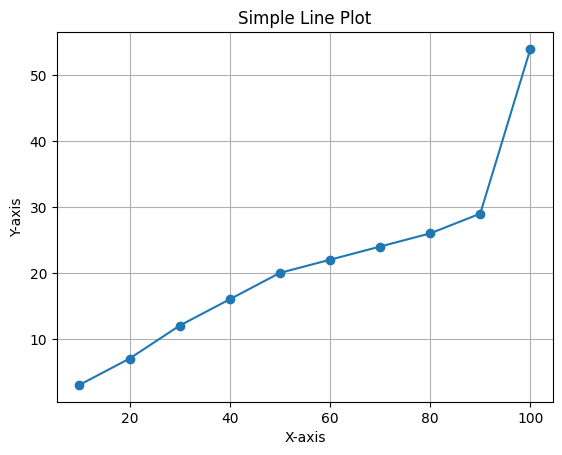

In [18]:
import matplotlib.pyplot as plt

x = SM_list
y=QPS_list
# y = []
# for i in QPS_list:
#     print(i)
#     y.append(i.batch)
plt.plot(x, y, marker='o')  # 使用'o'标记点

# 添加标题和标签
plt.title("Simple Line Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.grid(True)

# 显示图表
plt.show()
